# 8200-BiomX Challange: Phage Classification
### &copy; Doron Serebro
This notebook is a draft for the 8200-BiomX challange. The main goal is to classify DNA sequences to either bacteria or phage. Secondary goal is to identify the bacteria and the phage type (compare to NCBI) 

The noteboke contains the main logic and flow of the challange. Helper functions are available here:
* my_utils.py
* encodeFASTA.py  - my patch for [fasta_one_hot_encoder](https://github.com/LucaCappelletti94/fasta_one_hot_encoder) that supports varying length sequences


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Setup
Let's start with some imports and configurations.

In [ ]:
# /content/drive/MyDrive/Code/Phage Classification/
import os
from glob import glob
import matplotlib.pyplot as plt;
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import sys

# define home dir and import my modules
DATA_DIR = "/content/drive/MyDrive/Code/PhageClassification"
sys.path.append(DATA_DIR)
from my_utils import *
from encodeFASTA import FastaEncoder




# magics
%matplotlib inline
%load_ext autoreload
%autoreload 2

### Parameters
Here we define some useful parameters for the rest of the notebok

In [ ]:
# define constants
DUMMY_FASTA = f"{DATA_DIR}/example_training_genes.fasta"
TRAIN_FASTA = f"{DATA_DIR}/train.fasta"
TEST_FASTA = f"{DATA_DIR}/test_shuffled.fasta"


USE_GPU = 0 # SET THIS TO 1 IF RUNNING WITH A GPU RUNTIME
USE_REG = 0
DNA_SEQUENCE_CLIP=500
BATCH_SIZE = 16
VAL_SIZE = 3500
NUM_EPOCHS = 100
OPT = keras.optimizers.Adam(learning_rate=0.001)
LOSS = keras.losses.BinaryCrossentropy(from_logits=False)
METRICS = [keras.metrics.BinaryAccuracy(), tf.keras.metrics.AUC()]

### GPU
For faster runtime during training, it is reccomended to use a GPU.


In [ ]:
# GPU usage
device_name = tf.test.gpu_device_name()
if USE_GPU==1:
  if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
  else:
    print('Found GPU at: {}'.format(device_name))

### Load Data
The data for this challange is a .fasta file containing ~10k DNA sequences.

Each 2 consecutive line in a .fasta file represent a single DNA sequence. The first line is the sequence name and and the seconds line is the sequence itself. Example from the training set:

```
>Phage-4995
ATGACGGCTGATCAGGTGTTTAACCAAGTGCTGCCTGAAGCTTACAAGCTT...
```

Instead of working with a string representation, let's use [fasta_one_hot_encoder](https://github.com/LucaCappelletti94/fasta_one_hot_encoder) which loads and encodes a .fasta file in a single function.

One hot encoding is useful as it converts each DNA sequence to a 2D-array of size (sequence_length,4). This essentially means that our input data is a binary image and that allows us to utilize CNNs easily.

*In order to deal with sequences of varying lengths, I added zero-padding to fasta-one-hot-encoder.

In [ ]:
# my fix for FastaOneHotEncoder that supports sequences of varying lengths
fastaEncoder = FastaEncoder(nucleotides = "acgt", lower = True, sparse = False, handle_unknown="ignore")

# Load DNA sequences from FASTA
train_seqs = fastaEncoder.transform(TRAIN_FASTA)
train_seqs = train_seqs.astype(np.float32)
print(f"training set shape: {train_seqs.shape}")
print("generating labels for train dataset")

# Load labels from FASTA file
train_labels, train_ids = get_training_labels(TRAIN_FASTA,train_seqs.shape[0],2000)

training set shape: (9998, 9948, 4)
generating labels for train dataset
parsed 2000 contigs
parsed 4000 contigs
parsed 6000 contigs
parsed 8000 contigs


## EDA
So far we know that the training data is roughly 10k sequences, and that the largest DNA sequence is of length 9,948.
Let's get a better understanding of the data we're dealing with here:

In [ ]:
num_phages = np.count_nonzero(train_labels)
num_bact = train_labels.shape[0] - num_phages
print(f"Training set has {num_phages} phage sequences and {num_bact} bacteria sequences")

Training set has 4998 phage sequences and 5000 bacteria sequences


In [ ]:
# check labels of a given line
test_line = 2 #play around with this to check different sequences
print(f"train contig id#{train_ids[2]}: {train_labels[2]}")
print(f"train contig id#{train_ids[5001]}: {train_labels[5001]}")

train contig id#5001: 0
train contig id#2: 1


Since each DNA sequence has a different length, we should check to see how the distribution of sequence length.

Text(0, 0.5, 'Log(Count)')

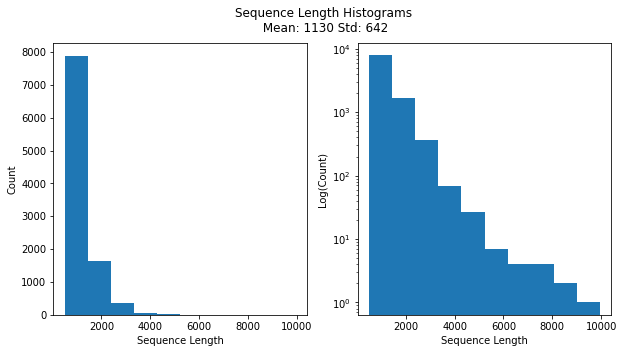

In [ ]:
#visualise sequence length
seq_lengths = []
bact_lengths = []
phage_lengths = []
for i in range(train_seqs.shape[0]):
  curr_length = np.max(np.nonzero(train_seqs[i]))
  seq_lengths.append(curr_length)
  if train_labels[i] == 0 :
    bact_lengths.append(curr_length)
  else:
    phage_lengths.append(curr_length)

seq_lengths = np.array(seq_lengths)
bact_lengths = np.array(seq_lengths)
phage_lengths = np.array(seq_lengths)

plt.figure(figsize=(10,5))
plt.suptitle(f"Sequence Length Histograms\n Mean: {int(np.mean(seq_lengths))} Std: {int(np.std(seq_lengths))}")
plt.subplot(1,2,1)
plt.hist(seq_lengths)
plt.xlabel("Sequence Length")
plt.ylabel("Count")
plt.subplot(1,2,2)
plt.hist(seq_lengths, log=True)
plt.xlabel("Sequence Length")
plt.ylabel("Log(Count)")

Let's compare

Text(0, 0.5, 'Count')

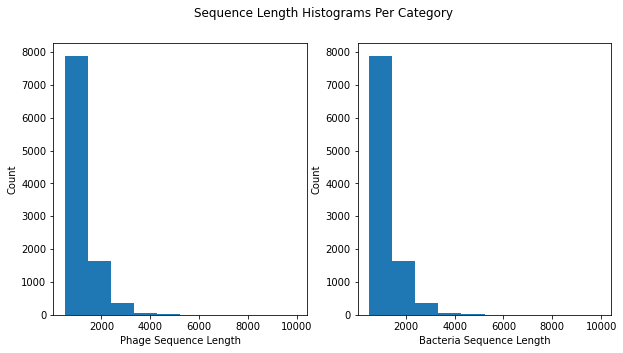

In [ ]:
plt.figure(figsize=(10,5))
plt.suptitle(f"Sequence Length Histograms Per Category")
plt.subplot(1,2,1)
plt.hist(phage_lengths)
plt.xlabel("Phage Sequence Length")
plt.ylabel("Count")
plt.subplot(1,2,2)
plt.hist(bact_lengths)
plt.xlabel("Bacteria Sequence Length")
plt.ylabel("Count")

Conclusions:
* dataset is balanced so we don't have to worry about label aguemntation or fancy loss for our model.
* Sequence length distributes roughly the same between labels. This is good since we won't havbe to worry about accidently learning sequence length as a feature.
* Looks like most sequences are roughly 1,000 samples long. This means that our dataset in currently mostly zeros obtains from zero-padding. Let's fix that.

## Sequence Splitting
If we use the current dataset as input to a model, it would be problematic due to 2 reasons:
1. In most cases, the input data would be dominated by zeros obtained by zero-padding from length ~1k to ~10k.
2. The input dimension is very large and would mean our model would be very large 

In order to deal with this issue, let's define a maximum length of 500 and split each sequence to smaller sequences of length 500. 

For example, a sequence of length 1,507 would be split into 3 sequences of length 500 and the remaining 7 samples would be ignored.


Advanteges:

*   No need for zero padding
*   Constant and small input dimension
*   Easy to Implement

Disadvanteges:

*   Loss of imformation due to ignored samples
*   Loss of imformation due split sequences (representation constraints)


In [ ]:
# create_dataset is available under my_utils.py
train_dataset_split = create_dataset(train_seqs,train_labels)

building dataset from 9998 sequences split into 18241 sequences of length 500


The last step before we can build and train a model is to shuffle the data and split it into a validation set:

In [ ]:
# Shuffle dataset, create validation set
shuffled_dataset = train_dataset_split.shuffle(buffer_size=20000)
full_trainset = shuffled_dataset.batch(BATCH_SIZE) # will be used for final training
val_dataset = shuffled_dataset.take(3500).batch(BATCH_SIZE)
train_dataset = shuffled_dataset.skip(3500).batch(BATCH_SIZE)

## Build Model
The model below is inspired by this article:

[Enhancer Identification using Transfer and Adversarial Deep Learning of DNA Sequences](https://www.biorxiv.org/content/biorxiv/early/2018/02/14/264200.full.pdf)


**Why Use 1D Convolutions?**

The information we seek to learn from DNA sequences comes mostly in the form of specific protein sequences (k-mers, motifs, etc..). This means that a 1D covolution is more suited for our model than the "classic" 2D convolution which learns spatial features.




In [ ]:
def create_model():
  # initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=1.)
  if USE_REG==1:
    l2_reg = tf.keras.regularizers.L2(0.01)
  else:
    l2_reg = None
  model = keras.Sequential(
      [
        layers.Conv1D(input_shape=(500, 4), filters=4, kernel_size=9, strides=1, activation="relu", kernel_regularizer=l2_reg),
        layers.MaxPool1D(3),
        layers.Conv1D(filters=20, kernel_size=5, strides=1, activation="relu", kernel_regularizer=l2_reg),
        layers.MaxPool1D(4),
        layers.Conv1D(filters=30, kernel_size=3, strides=1, activation="relu", kernel_regularizer=l2_reg),
        layers.MaxPool1D(4),
        layers.Flatten(),
        layers.Dense(90, activation="relu", kernel_regularizer=l2_reg),
        layers.Dropout(0.5),
        layers.Dense(45, activation="relu", kernel_regularizer=l2_reg),
        # layers.Dropout(0.5),
        layers.Dense(1, activation="sigmoid"),
      ]
  )
  return model

#create a model on the CPU jsut for summary()
model = create_model()
model.compile(optimizer=OPT,loss=LOSS,metrics=METRICS)
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_18 (Conv1D)           (None, 492, 4)            148       
_________________________________________________________________
max_pooling1d_18 (MaxPooling (None, 164, 4)            0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 160, 20)           420       
_________________________________________________________________
max_pooling1d_19 (MaxPooling (None, 40, 20)            0         
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 38, 30)            1830      
_________________________________________________________________
max_pooling1d_20 (MaxPooling (None, 9, 30)             0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 270)              

### Train With Validation Split

In [ ]:
#TODO: add early stopping using tf.keras.callbacks.EarlyStopping
with tf.device('/device:GPU:0'):
  model_gpu = create_model()
  model_gpu.compile(optimizer=OPT,loss=LOSS,metrics=METRICS)
  train_hist = model_gpu.fit(train_dataset, epochs=NUM_EPOCHS, validation_data=val_dataset)

Epoch 1/100
922/922 [==============================] - 6s 5ms/step - loss: 0.6935 - binary_accuracy: 0.5110 - auc_2: 0.5029 - val_loss: 0.6922 - val_binary_accuracy: 0.5214 - val_auc_2: 0.5071
Epoch 2/100
922/922 [==============================] - 5s 5ms/step - loss: 0.6829 - binary_accuracy: 0.5466 - auc_2: 0.5730 - val_loss: 0.6481 - val_binary_accuracy: 0.6329 - val_auc_2: 0.6876
Epoch 3/100
922/922 [==============================] - 5s 5ms/step - loss: 0.6288 - binary_accuracy: 0.6463 - auc_2: 0.6983 - val_loss: 0.5966 - val_binary_accuracy: 0.6863 - val_auc_2: 0.7517
Epoch 4/100
922/922 [==============================] - 5s 5ms/step - loss: 0.6051 - binary_accuracy: 0.6742 - auc_2: 0.7329 - val_loss: 0.5706 - val_binary_accuracy: 0.7151 - val_auc_2: 0.7830
Epoch 5/100
922/922 [==============================] - 5s 5ms/step - loss: 0.5871 - binary_accuracy: 0.6922 - auc_2: 0.7552 - val_loss: 0.5649 - val_binary_accuracy: 0.6986 - val_auc_2: 0.7821
Epoch 6/100
922/922 [==============

* **NOTE!** When rerunning this notebook, you may have to change the key for the auc plots. Just make sure the plot matches the auc name outputted by model.fit(). Currently it is set to "auc_2" but rerunning would probably cause it to reset to just "auc"

Validation Loss:0.14
Validation Accuracy: 0.96
Validation AUC: 0.99


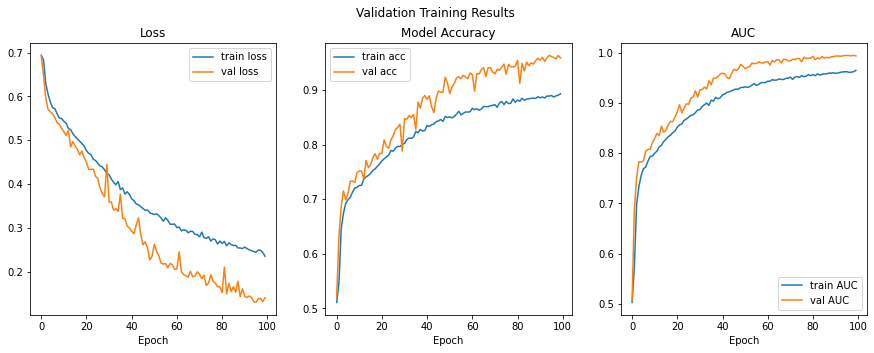

In [ ]:
val_loss = train_hist.history["val_loss"][-1]
val_acc = train_hist.history["val_binary_accuracy"][-1]
val_auc = train_hist.history["val_auc_2"][-1]
print(f"Validation Loss:{val_loss:.2f}\nValidation Accuracy: {val_acc:.2f}\nValidation AUC: {val_auc:.2f}")
plt.figure(figsize=(15, 5))
plt.suptitle(f"Validation Training Results")
plt.subplot(1,3,1)
plt.plot(train_hist.history["loss"])
plt.plot(train_hist.history["val_loss"])
plt.legend(["train loss", "val loss"])
plt.xlabel("Epoch")
plt.title("Loss")
plt.subplot(1,3,2)
plt.plot(train_hist.history["binary_accuracy"])
plt.plot(train_hist.history["val_binary_accuracy"])
plt.legend(["train acc", "val acc"])
plt.xlabel("Epoch")
plt.title("Model Accuracy")
plt.subplot(1,3,3)
plt.plot(train_hist.history["auc_2"])
plt.plot(train_hist.history["val_auc_2"])
plt.xlabel("Epoch")
plt.title("AUC")
plt.legend(["train AUC", "val AUC"])

In [ ]:
model_gpu.save(f"{DATA_DIR}/models/model0608_96val_acc.h5", save_format='h5')

Looks like we have a pretty good model. In order to make it even better, let's train on the entire dataset (remove the validation split) for the final evaluation that will be performed on the test set.

*It is quit strange that validation results are better than training results. This might be explained by the fact that during validation dropout is not applied or by the fact that our validation set is too small to represent a good test case.

### Train Using All Data


In [ ]:
with tf.device('/device:GPU:0'):
  final_model_gpu = create_model()
  final_model_gpu.compile(optimizer=OPT,loss=LOSS,metrics=METRICS)
  final_train_hist = final_model_gpu.fit(full_trainset, epochs=NUM_EPOCHS)

Epoch 1/100
1141/1141 [==============================] - 6s 4ms/step - loss: 0.6926 - binary_accuracy: 0.5918 - auc_2: 0.6403
Epoch 2/100
1141/1141 [==============================] - 5s 4ms/step - loss: 0.6404 - binary_accuracy: 0.6264 - auc_2: 0.6795
Epoch 3/100
1141/1141 [==============================] - 5s 4ms/step - loss: 0.5869 - binary_accuracy: 0.6975 - auc_2: 0.7570
Epoch 4/100
1141/1141 [==============================] - 5s 5ms/step - loss: 0.5733 - binary_accuracy: 0.7031 - auc_2: 0.7708
Epoch 5/100
1141/1141 [==============================] - 5s 4ms/step - loss: 0.5640 - binary_accuracy: 0.7129 - auc_2: 0.7802
Epoch 6/100
1141/1141 [==============================] - 5s 4ms/step - loss: 0.5550 - binary_accuracy: 0.7195 - auc_2: 0.7891
Epoch 7/100
1141/1141 [==============================] - 5s 4ms/step - loss: 0.5509 - binary_accuracy: 0.7196 - auc_2: 0.7920
Epoch 8/100
1141/1141 [==============================] - 5s 4ms/step - loss: 0.5442 - binary_accuracy: 0.7262 - auc_2:

Text(0.5, 0, 'Epoch')

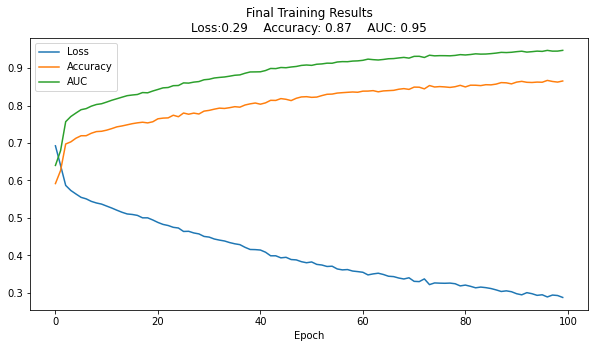

In [ ]:
final_loss = final_train_hist.history["loss"][-1]
final_acc = final_train_hist.history["binary_accuracy"][-1]
final_auc = final_train_hist.history["auc_2"][-1]
plt.figure(figsize=(10, 5))
plt.title(f"Final Training Results\nLoss:{final_loss:.2f}    Accuracy: {final_acc:.2f}    AUC: {final_auc:.2f}")
plt.plot(final_train_hist.history["loss"])
plt.plot(final_train_hist.history["binary_accuracy"])
plt.plot(final_train_hist.history["auc_2"])
plt.legend(["Loss", "Accuracy", "AUC"])
plt.xlabel("Epoch")

Let's save our model for future work:

In [ ]:
final_model_gpu.save(f"{DATA_DIR}/models/final_model.h5", save_format='h5')

## Generate Submission
Inference is slightly different than training. Instead of splitting sequences and treating them as independant dataset elements, we must now perform an ensemble of all sequences and give a single prediction per sequence.

Additionally, instead of labels, the sequence names are IDs which we need to pair each sequence with for the submission csv.

### Load Test Data
In order to properly load the test data we must create pairs of sequence IDs and one=hot encoded DNA sequences:

In [ ]:
test_seqs = fastaEncoder.transform(TEST_FASTA)
test_seqs = test_seqs.astype(np.float32)

# get_test_labels available under my_utils.py
test_ids = get_test_labels(TEST_FASTA,test_seqs.shape[0],500)
print(f"Test sequences shape: {test_seqs.shape} Test IDs shape: {test_ids.shape}")

parsed 500 contigs
parsed 1000 contigs
parsed 1500 contigs
parsed 2000 contigs
Test sequences shape: (2001, 7782, 4) Test IDs shape: (2001,)


### Inference
Using pandas we can easily build a DataFrame to hold the ids and generate a prediction for each sequence in the test

In [ ]:
#build a df for our submission csv
submission_df = pd.DataFrame(columns=["Contig Name", "Classification", "Probability Score", "tax_id"])
submission_df["Contig Name"] = test_ids
submission_df["Probability Score"] = get_preds(test_seqs, final_model_gpu) # available in my_utils.py
submission_df["Classification"] = submission_df["Probability Score"].apply(pred2class) # probability to class

parsed 0 sequences
parsed 100 sequences
parsed 200 sequences
parsed 300 sequences
parsed 400 sequences
parsed 500 sequences
parsed 600 sequences
parsed 700 sequences
parsed 800 sequences
parsed 900 sequences
parsed 1000 sequences
parsed 1100 sequences
parsed 1200 sequences
parsed 1300 sequences
parsed 1400 sequences
parsed 1500 sequences
parsed 1600 sequences
parsed 1700 sequences
parsed 1800 sequences
parsed 1900 sequences
parsed 2000 sequences


In [ ]:
submission_df.to_csv(f"{DATA_DIR}/Submissions/final_submission.csv",index=False)
submission_df

,Contig Name,Classification,Probability Score,tax_id
0,12374,Bacteria,0.252227,NaN
1,11562,Phage,0.999088,NaN
2,14190,Bacteria,0.089380,NaN
3,14155,Bacteria,0.022736,NaN
4,13004,Bacteria,0.292622,NaN
...,...,...,...,...
1996,13007,Bacteria,0.239517,NaN
1997,11423,Phage,0.640368,NaN
1998,12610,Bacteria,0.354973,NaN
1999,13352,Bacteria,0.000067,NaN


In [ ]:
submission_df.Classification.value_counts()

Phage       1014
Bacteria     987
Name: Classification, dtype: int64

## Future Plans
### 1. Data augmentations
Better data means better learning. Currently, the dataset is not being fully utilized. First of all, I'm literally ignoring chunks of data since I arbitraily chose an input dimension of 500


### 2. Hyperparameter tuning (learning-rate, sequence length)
Given more time, I would've tried to further improve results by additional tuning of the model's hyperparamaters. Maybe use Keras Tuner for hyperparameters search.


### 3. Sliding window slicing for inference mode
Currently inference is using the same slicing mechanism as training which simpley cuts the sequence after every 500 characters and calculate the mean prediction. A smarter idea is to use a sliding window approach that would ensure:
1. Overlap between different slices means less information is lost due to the slicing operation
2. The entire input sequence will be used


### 4. Different model types
Ideally, the model would be able to handle DNA of any length without slicing them into smaller sequences and losing the sequence information. For this task, a CNN is probably not the best idea (it was just the easiest for me to implement on a short notice). Some better models might include:
* a RNN elemnt (GRU, or bi-directional GRU) that is able to process sequence data without any constraints on the input dimension
* An embedding mechanism. Recent years has shown just how powerful representation learning can be. If had more time and compute power, I would've tried to use dna2vec as an embedding layer or maybe even train some sort of autoencoder to map DNA sequences into a latent space.
